# Full CIFAR10 Dataset

In [1]:
# Full CIFAR10
import os.path

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

In [2]:
# Data directory
data_dir = '../datasets'

False


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Training set
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                                        download=True, transform=transform)
trainset = torch.utils.data.DataLoader(trainset, batch_size=4,
                                       shuffle=True, num_workers=2)

# Testing set
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=transform)
testset = torch.utils.data.DataLoader(testset, batch_size=4,
                                      shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Labels: cat ship ship plane


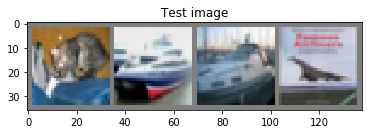

In [4]:
# Plotting few examples
def imshow(img, smooth=False):
    # Unnormalize the image
    img = img / 2 + 0.5  # unnormalize image
    np_img = img.numpy()
    # Smooth parameter
    smooth = 'spline16' if smooth else 'nearest'
    # Plot the image
    plt.title('Test image')
    plt.imshow(np.transpose(np_img, (1, 2, 0)), interpolation=smooth)


# Load images
data = iter(testset)
images, labels = data.next()

# Show images and labels
imshow(torchvision.utils.make_grid(images))
print('Labels: {}'.format(' '.join(classes[ labels[i] ] for i in range(4))))

In [5]:
class Network(nn.Module):
    def __init__(self, **kwargs):
        super(Network, self).__init__()
        # Keyword arguments
        self._img_channel = kwargs.get('img_channel', 3)
        self._num_classes = kwargs.get('num_classes', 10)
        
        # Network structure
        self.conv1 = nn.Conv2d(self._img_channel, 16, 4)
        self.conv2 = nn.Conv2d(16, 64, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*5*5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self._num_classes)
        
    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        # Flatten layer
        x = x.view(-1, self._flatten(x))
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(F.dropout(self.fc2(x), p=0.5))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
    def _flatten(self, x):
        size = x.size()[1:]
        return torch.Tensor(size).numel()

In [6]:
net = Network(img_channel=3, num_classes=10)

In [7]:
# Loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [8]:
# Training loop
for epoch in range(5):
    
    for i, data in enumerate(trainset):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        # Forward + loss 
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()  # Back propagate
        # Updates learnable params
        optimizer.step()
        
        print(f'\rEpoch: {epoch+1:,}\tIter: {i+1:,}\tLoss: {loss.data[0]:.4f}', end='')
    print()
print('Finished training!')

Epoch: 1	Iter: 12,500	Loss: 2.4612
Epoch: 2	Iter: 12,500	Loss: 2.4612
Epoch: 3	Iter: 12,500	Loss: 2.2112
Epoch: 4	Iter: 12,500	Loss: 2.4612
Epoch: 5	Iter: 12,500	Loss: 1.9612
Finished training!
